# Strategy 2: Global Motion Compensation (GMC) with Dynamic Thresholding & Persistence Tracking on CPU

# Step 1: Prep
Run this section only once to move the files over from your drive. This will setup the environment needed to run the pipeline.

- Move the files to your personal Drive
  - trainxs.zip
  - annotations/train.json.
- Location of the files:
https://drive.google.com/drive/folders/1ES3tEWHM2VKRNEeBI_XKR1sHioi3aRTY?usp=sharing

In [1]:
 #@title Install missing pip package
 !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00


In [2]:
#@title Move data from Google Drive and unzip.
import os
import shutil
import time
from google.colab import drive

# ==========================================
# 1. MOUNT DRIVE (The "Vault")
# ==========================================
# This gives access to your permanent storage
drive.mount('/content/drive')

# Paths
# Get the trainxs.zip and annotations/train.json from:
# https://drive.google.com/drive/folders/1ES3tEWHM2VKRNEeBI_XKR1sHioi3aRTY?usp=sharing
DRIVE_BASE_PATH = '/content/drive/MyDrive'
DRIVE_ZIP_PATH = DRIVE_BASE_PATH + '/Oxford/study/VIS/phase_1/trainxs.zip'
DRIVE_ANNOTATION_PATH = DRIVE_BASE_PATH + '/Oxford/study/VIS/phase_1/annotations/train.json'
# Local storage in colab
LOCAL_ZIP_PATH = '/content/trainxs.zip'
LOCAL_DATA_DIR = '/content/data_local'
LOCAL_ANNOTATION_PATH = '/content/train.json'

# ==========================================
# 2. COPY & UNZIP (The Speed Hack)
# ==========================================

shutil.copy(DRIVE_ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)

if not os.path.exists(LOCAL_DATA_DIR):
    print("🚀 Copying data from Drive to Local SSD (Fast)...")
    t0 = time.time()

    # Copy the ZIP from Drive to Colab Local Disk
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)

    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    # Unzip quietly (-q) to avoiding spamming output
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')

    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")
else:
    print("✅ Data already loaded locally.")

# ==========================================
# 3. CONFIGURE YOUR STRATEGY
# ==========================================
# Point your existing code to look at the LOCAL folder, not Drive
TRAIN_DIR = os.path.join(LOCAL_DATA_DIR, 'trainxs')
# (Make sure this matches the folder structure inside your zip)

Mounted at /content/drive
🚀 Copying data from Drive to Local SSD (Fast)...
📦 Unzipping... (This is fast on Colab SSD)
✅ Data Ready! Setup took: 58.82s


# Step 2: Run the Strategy 2 Pipeline
Global Motion Compensation (GMC) with Dynamic Thresholding & Persistence Tracking

This strategy implements a robust Computer Vision pipeline designed to detect small moving objects (birds) by isolating independent motion from camera motion and variable background noise. It operates without deep learning (No Neural Networks) and runs efficiently on CPU.

1. Global Motion Compensation (GMC)
- Goal: To neutralize camera movement (panning/shaking) so that the background remains static between frames.
- Feature Tracking: We detect "Shi-Tomasi" corners in the previous frame (prev_gray) and track their position in the current frame (curr_gray) using Lucas-Kanade Optical Flow.
- Homography Alignment: Using the vector field of these tracked points, we compute a Homography Matrix using RANSAC (to ignore outliers like the moving bird itself).
- Warping: The previous frame is geometrically warped to align perfectly with the current frame. This effectively "stabilizes" the background.
2. Frame Differencing
- We compute the Absolute Difference (cv2.absdiff) between the current frame and the aligned previous frame.
- Ideally: The background subtracts to zero (Black), and moving objects appear as non-zero intensity clusters (White).
3. Dynamic Statistical Thresholding
- Problem: Fixed thresholds fail because environmental noise varies. A windy scene with shaking leaves generates high-intensity difference noise ("ghosting"), while a calm scene has low noise.
- Solution: We calculate the Mean ($\mu$) and Standard Deviation ($\sigma$) of the difference image for every frame.
- Adaptive Threshold: We set the binary threshold dynamically:$$T = \text{clamp}(\mu + (4 \times \sigma), 20, 80)$$
- Logic: This ensures we only detect pixels that are statistically significant outliers (birds) relative to the current background chaos level. If the trees shake ($\sigma$ increases), the threshold $T$ rises automatically to ignore them. We clamp the value between 20 and 80 to prevent it from becoming too extreme.
4. Morphological Noise Removal
- Opening: We apply a Morphological Opening (Erosion followed by Dilation) using a $5 \times 5$ elliptical kernel. This removes isolated "sparkle" noise (single pixels) while preserving larger structures.
- Dilation: We slightly dilate the remaining regions to connect fragmented parts of the bird into a single cohesive blob.
5. Contour FilteringDetection: We extract contours from the binary mask.
- Filters: We apply heuristic filters to discard non-bird objects:Area: Reject blobs that are too small (sensor noise) or too large (alignment artifacts). ($50 < \text{Area} < 5000$).Aspect Ratio: Reject long, thin lines (e.g., wave crests, branch edges) using a ratio filter ($0.2 < W/H < 4.0$).
- Border: Reject detections that touch the edge of the frame (often artifacts from the warping process).
6. Persistence Tracking (Temporal Filtering)
- Logic: Leaves and noise often appear for a single frame and then vanish. Real birds persist over time.
- Tracker: We map detections across frames using a nearest-neighbor distance metric.
- Min Hits: A track is only considered "Valid" and written to the output if it has been successfully detected in at least 3 consecutive frames. This "warm-up" period filters out transient noise.

In [7]:
#@title Config
# Number of videos to run this pipeline (up to the index or all of the videos)
SHOULD_LIMIT_VIDEO = 100
# if SHOULD_LIMIT_VIDEO == 1 then use the following to grab exact indexes of videos to process.
VIDEO_INDEXES = [4]

# Final output CSV
OUTPUT_CSV_PATH = './strat_2_dynamic_cpu.csv'

In [8]:
#@title Main strategy logic
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import glob
import cv2
import json
import sys
import pandas as pd
import numpy as np
import warnings
import math
from collections import defaultdict
import re

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 2. AUTHENTICATION & DATA VERIFICATION
# ==========================================
print(f"\n🚀 CHECKING DATA...")

# A. Check Annotations
if not os.path.exists(LOCAL_ANNOTATION_PATH):
    print(f"⬇️ 'train.json' not found")
    if os.path.exists(DRIVE_ANNOTATION_PATH):
        print(f"⬇️ 'train.json' Downloading...")
        shutil.copy(DRIVE_ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)
else:
    print("✅ Annotations found locally.")

# B. Check Video Data
if os.path.exists(TRAIN_DIR) and len(os.listdir(TRAIN_DIR)) > 0:
    print(f"✅ Training data found in '{TRAIN_DIR}'. Skipping download.")
else:
    print(f"⬇️ Data not found. Downloading from Drive...")
    t0 = time.time()
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')
    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")

# ==========================================
# 3. MOTION COMPENSATION LOGIC (CPU)
# ==========================================
def align_frames(prev_gray, curr_gray):
    """
    Calculates camera motion and warps prev_gray to match curr_gray.
    """
    # 1. Detect Features
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None

    # 2. Optical Flow
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]

    if len(good_prev) < 4: return None

    # 3. Find Homography
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None

    # 4. Warp
    height, width = prev_gray.shape
    warped_prev = cv2.warpPerspective(prev_gray, H, (width, height))
    return warped_prev

# ==========================================
# 4. HELPER FUNCTIONS (TRACKING & METRICS)
# ==========================================
class ObjectTracker:
    def __init__(self, dist_thresh=50, max_frames_to_skip=5, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.min_hits = min_hits

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        assigned_dets = set()
        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1
            # Euclidean distance center-to-center
            cx_t, cy_t = track['box'][0]+track['box'][2]/2, track['box'][1]+track['box'][3]/2

            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                cx_d, cy_d = det[0]+det[2]/2, det[1]+det[3]/2
                d = ((cx_t-cx_d)**2 + (cy_t-cy_d)**2)**0.5
                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                track['skipped'] += 1

        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        self.tracks = [t for t in self.tracks if t['skipped'] <= self.max_frames_to_skip]
        return [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]

def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

def get_center(box):
    return (box[0] + box[2]/2, box[1] + box[3]/2)

def calculate_center_distance(box1, box2):
    c1 = get_center(box1)
    c2 = get_center(box2)
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def get_next_version_path(path):
    if not os.path.exists(path): return path
    directory, filename = os.path.split(path)
    name, ext = os.path.splitext(filename)
    if directory and not os.path.exists(directory): os.makedirs(directory)
    pattern = re.compile(rf"^{re.escape(name)}_(\d+){re.escape(ext)}$")
    max_version = 0
    for f in os.listdir(directory if directory else '.'):
        match = pattern.match(f)
        if match:
            version = int(match.group(1))
            if version > max_version: max_version = version
    return os.path.join(directory, f"{name}_{max_version + 1}{ext}")

# ==========================================
# 5. MAIN PIPELINE
# ==========================================
def run_gmc_evaluation():
    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    if not gt_data: return

    start_time = time.time()

    # Select the videos that will be processed based on config.
    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    if SHOULD_LIMIT_VIDEO:
      if SHOULD_LIMIT_VIDEO == 1:
        new_video_folders = []
        for ind in VIDEO_INDEXES:
          new_video_folders.append(video_folders[ind])
        video_folders = new_video_folders
      else:
        video_folders = video_folders[:min(len(video_folders),SHOULD_LIMIT_VIDEO)]

    if not video_folders:
        print(f"❌ No video folders found in {TRAIN_DIR}.")
        return

    print(f"📂 Found {len(video_folders)} videos. Starting GMC + Dynamic Thresholding...")

    total_tp = total_fp = total_fn = total_time = total_frames = 0
    results_data = []

    print(f"\n{'Video':<10} | {'Frames':<6} | {'FPS':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6}")
    print("-" * 65)

    for video_path in video_folders:
        video_name = os.path.basename(video_path)
        images = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
        if not images: continue

        vid_tp = vid_fp = vid_fn = 0
        vid_start = time.time()
        n_frames = len(images)
        prev_gray = None
        tracker = ObjectTracker(dist_thresh=50, min_hits=3)

        for i, img_path in enumerate(images):
            if i % 50 == 0:
                percent = ((i + 1) / n_frames) * 100
                sys.stdout.write(f"\r👉 Processing [{video_name}] Frame {i+1}/{n_frames} ({percent:.1f}%)")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            if frame is None: continue
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            raw_detections = []

            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    # --- NEW LOGIC START ---

                    # 1. Calculate Difference
                    diff = cv2.absdiff(curr_gray, warped_prev)

                    # 2. Dynamic Thresholding
                    # Calculate stats of the difference image to find "background noise level"
                    mean, std = cv2.meanStdDev(diff)
                    # Threshold = Mean + 4 * Standard_Deviation
                    # This implies: Only keep pixels that are SIGNIFICANTLY brighter than the noise
                    dynamic_thresh = mean[0][0] + 4.0 * std[0][0]
                    # Clamp threshold to reasonable bounds (e.g., between 20 and 80)
                    final_thresh = max(20, min(80, dynamic_thresh))

                    _, thresh = cv2.threshold(diff, final_thresh, 255, cv2.THRESH_BINARY)

                    # 3. Morphological Opening (Erase small sparkles)
                    # This removes isolated white pixels (leaves/noise)
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
                    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

                    # Dilate slightly to connect bird parts
                    thresh = cv2.dilate(thresh, kernel, iterations=1)

                    # --- NEW LOGIC END ---

                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    h_img, w_img = curr_gray.shape

                    for cnt in contours:
                        area = cv2.contourArea(cnt)
                        # Filter noise
                        if 50 < area < 5000:
                            x, y, w, h = cv2.boundingRect(cnt)

                            # Aspect Ratio Filter (Birds aren't usually super long lines)
                            aspect_ratio = float(w)/h
                            if 0.2 < aspect_ratio < 4.0:
                                # Border check
                                border = 15
                                if x > border and y > border and (x+w) < (w_img-border) and (y+h) < (h_img-border):
                                    raw_detections.append([x, y, w, h])

            prev_gray = curr_gray

            # Tracking
            final_preds = tracker.update(raw_detections)

            # Evaluation
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])
            matched_gt = set()

            for p_box in final_preds:
                best_dist = 10000
                best_idx = -1
                for idx, g_box in enumerate(gts):
                    if idx in matched_gt: continue
                    d = calculate_center_distance(p_box, g_box)
                    if d < best_dist: best_dist = d; best_idx = idx

                if best_dist <= 30:
                    vid_tp += 1
                    matched_gt.add(best_idx)
                else:
                    vid_fp += 1

            vid_fn += len(gts) - len(matched_gt)

        vid_time = time.time() - vid_start
        fps = len(images) / vid_time if vid_time > 0 else 0
        prec = vid_tp / (vid_tp + vid_fp) if (vid_tp + vid_fp) > 0 else 0
        rec = vid_tp / (vid_tp + vid_fn) if (vid_tp + vid_fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        sys.stdout.write("\r" + " " * 80 + "\r")
        print(f"{video_name:<10} | {len(images):<6} | {fps:<6.1f} | {prec:<6.2f} | {rec:<6.2f} | {f1:<6.2f}")

        results_data.append({
            'Video': video_name, 'Frames': len(images), 'FPS': round(fps, 2),
            'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4),
            'TP': vid_tp, 'FP': vid_fp, 'FN': vid_fn
        })
        total_time += vid_time; total_frames += len(images)
        total_tp += vid_tp; total_fp += vid_fp; total_fn += vid_fn

    print("=" * 65)
    avg_fps = total_frames / total_time if total_time > 0 else 0
    overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_prec * overall_rec) / (overall_prec + overall_rec) if (overall_prec + overall_rec) > 0 else 0

    print("FINAL RESULTS (GMC + Dynamic Threshold + Persistence tracking):")
    print(f"Total Frames:   {total_frames}")
    print(f"Average FPS:    {avg_fps:.2f}")
    print(f"Precision:      {overall_prec:.4f}")
    print(f"Recall:         {overall_rec:.4f}")
    print(f"F1-Score:       {overall_f1:.4f}")
    print("=" * 65)

    df = pd.DataFrame(results_data)
    final_path = get_next_version_path(OUTPUT_CSV_PATH)
    df.to_csv(final_path, index=False)
    print(f"✅ CSV Saved: {final_path}")
    print(f"⏱️ Process took: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    run_gmc_evaluation()


🚀 CHECKING DATA...
✅ Annotations found locally.
✅ Training data found in '/content/data_local/trainxs'. Skipping download.
📂 Found 5 videos. Starting GMC + Dynamic Thresholding...

Video      | Frames | FPS    | Prec   | Recall | F1    
-----------------------------------------------------------------
0001       | 601    | 1.2    | 0.00   | 0.09   | 0.00  
0002       | 597    | 2.1    | 0.24   | 0.09   | 0.13  
0003       | 241    | 2.1    | 0.03   | 0.02   | 0.02  
0004       | 211    | 2.2    | 0.02   | 0.96   | 0.05  
0005       | 110    | 2.3    | 0.21   | 0.72   | 0.33  
FINAL RESULTS (GMC + Dynamic Threshold + Persistence tracking):
Total Frames:   1760
Average FPS:    1.69
Precision:      0.0007
Recall:         0.1109
F1-Score:       0.0014
✅ CSV Saved: ./strat_2_dynamic_cpu.csv
⏱️ Process took: 1039.10 seconds


# Debug
Print images of the following scenarios for each video:
1. Hits (where the model's prediction overlaps with the Ground Truth)
2. Distractions (where the model falsely detects background noise like leaves or waves).

🎯 Limiting Visualization to first 100 videos.
🕵️ Starting Scan across 5 videos...

🎬 VIDEO 1/5: 0001
   Scanning frame 0/601...
   📸 Frame 3: ⚠️ DISTRACTION (Predicted wrong object)


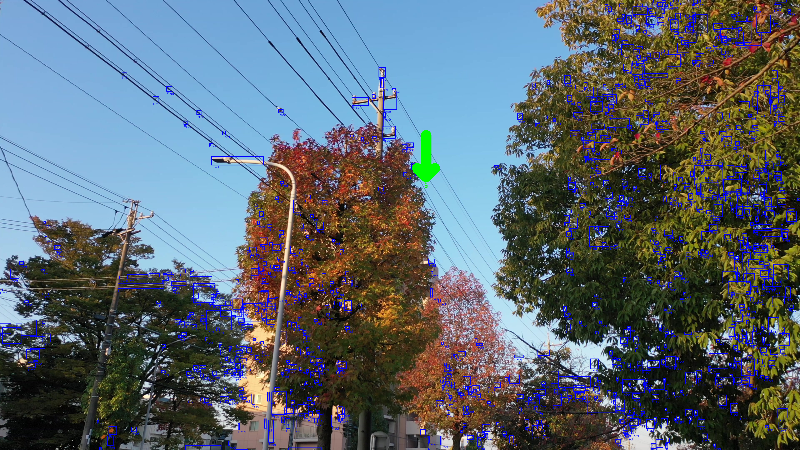


   📸 Frame 6: ✅ HIT (Accurate Detection)


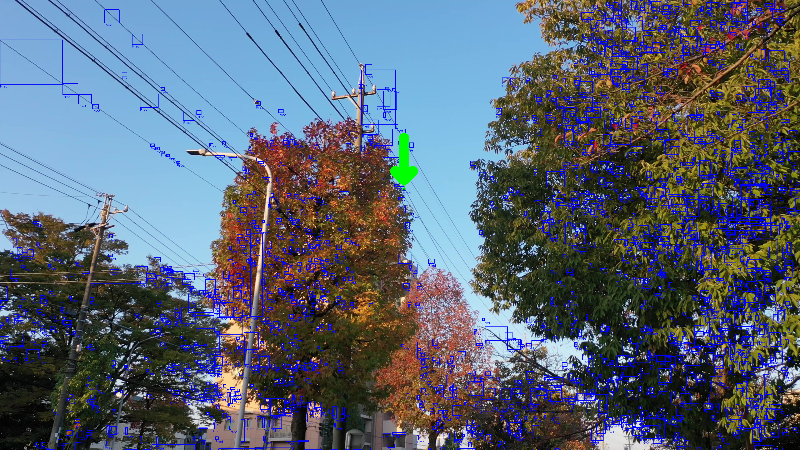

   ✅ Found examples. Moving to next video.

🎬 VIDEO 2/5: 0002
   Scanning frame 0/597...
   📸 Frame 5: ✅ HIT (Accurate Detection)


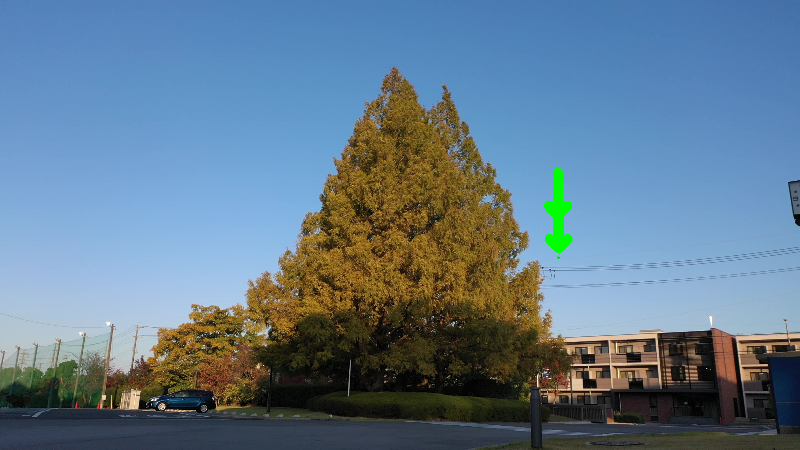

   Scanning frame 40/597...
   📸 Frame 52: ⚠️ DISTRACTION (Predicted wrong object)


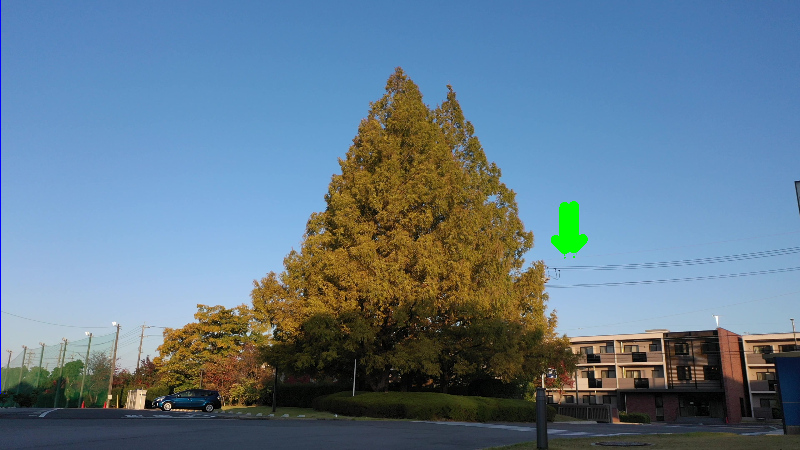

   ✅ Found examples. Moving to next video.

🎬 VIDEO 3/5: 0003
   Scanning frame 0/241...
   📸 Frame 3: ⚠️ DISTRACTION (Predicted wrong object)


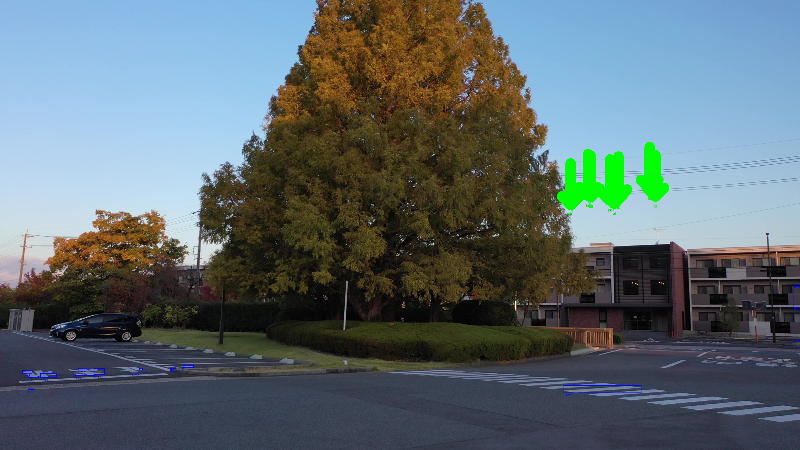


   📸 Frame 4: ✅ HIT (Accurate Detection)


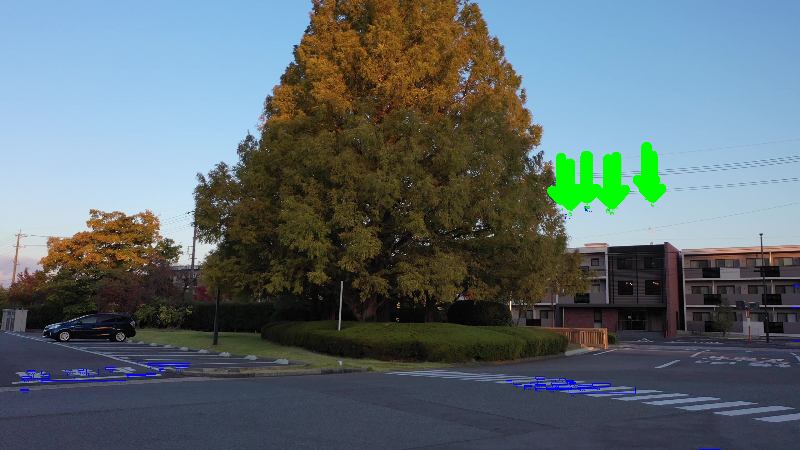

   ✅ Found examples. Moving to next video.

🎬 VIDEO 4/5: 0004
   Scanning frame 0/211...
   📸 Frame 3: ✅ HIT (Accurate Detection)


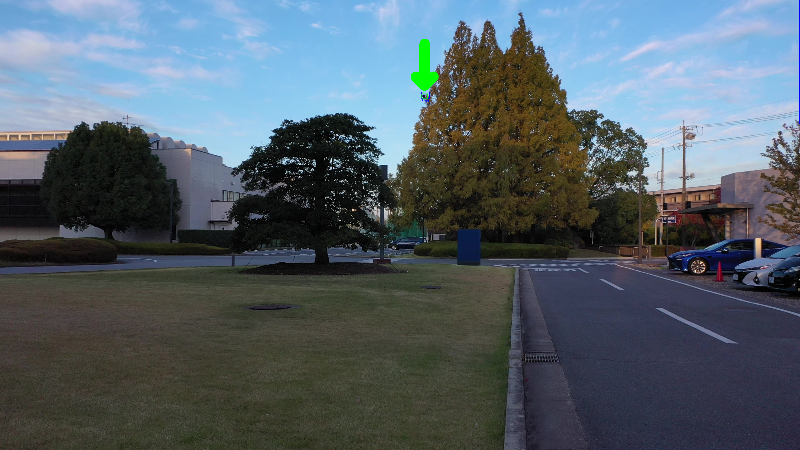

   Scanning frame 120/211...
   📸 Frame 131: ⚠️ DISTRACTION (Predicted wrong object)


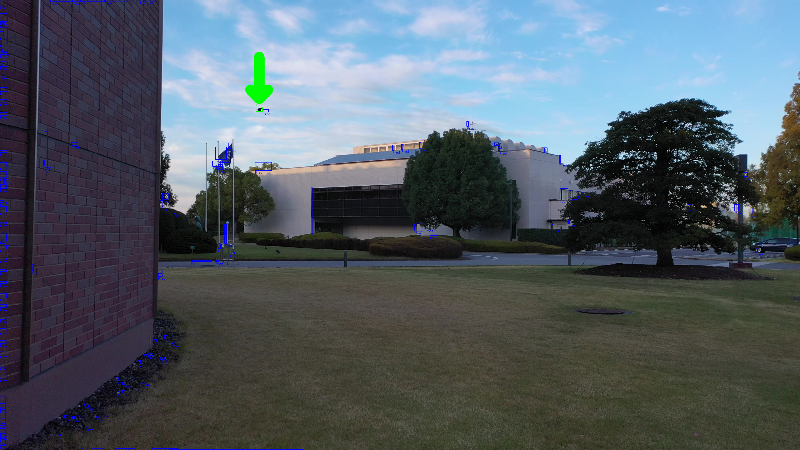

   ✅ Found examples. Moving to next video.

🎬 VIDEO 5/5: 0005
   Scanning frame 0/110...
   📸 Frame 3: ⚠️ DISTRACTION (Predicted wrong object)


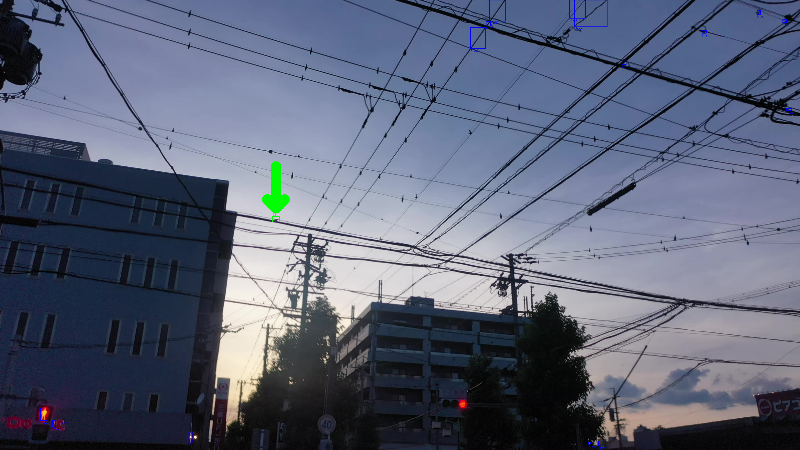


   📸 Frame 11: ✅ HIT (Accurate Detection)


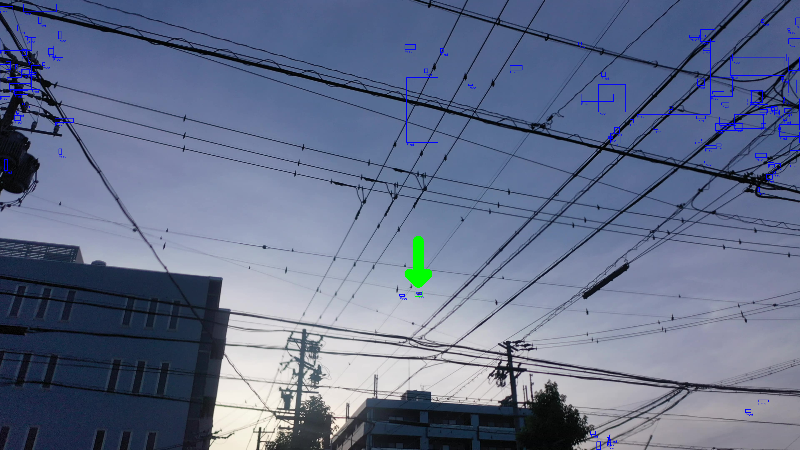

   ✅ Found examples. Moving to next video.


In [9]:
#@title Visualization
import glob
import os
import cv2
import sys
import numpy as np
from google.colab.patches import cv2_imshow

# Tracker Class (Required for Strategy Viz)
class ObjectTracker:
    def __init__(self, dist_thresh=50, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.min_hits = min_hits

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        assigned_dets = set()
        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1
            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                # Euclidean distance center-to-center
                cx_t, cy_t = track['box'][0]+track['box'][2]/2, track['box'][1]+track['box'][3]/2
                cx_d, cy_d = det[0]+det[2]/2, det[1]+det[3]/2
                d = ((cx_t-cx_d)**2 + (cy_t-cy_d)**2)**0.5

                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                track['skipped'] += 1

        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        self.tracks = [t for t in self.tracks if t['skipped'] <= 5]
        return [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]

# Helper Functions
def boxes_intersect(boxA, boxB):
    ax1, ay1, ax2, ay2 = boxA[0], boxA[1], boxA[0]+boxA[2], boxA[1]+boxA[3]
    bx1, by1, bx2, by2 = boxB[0], boxB[1], boxB[0]+boxB[2], boxB[1]+boxB[3]
    if (ax1 > bx2) or (ax2 < bx1) or (ay1 > by2) or (ay2 < by1): return False
    return True

def draw_arrow_pointer(img, x, y, w, h, color=(0, 255, 0)):
    center_x = int(x + w // 2)
    gap = 40
    arrow_len = 200
    if y < (gap + arrow_len):
        start_point = (center_x, y + h + gap + arrow_len)
        end_point = (center_x, y + h + gap)
    else:
        start_point = (center_x, y - gap - arrow_len)
        end_point = (center_x, y - gap)
    cv2.arrowedLine(img, start_point, end_point, color, thickness=50, tipLength=0.3)

def align_frames(prev_gray, curr_gray):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]
    if len(good_prev) < 4: return None
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None
    height, width = prev_gray.shape
    return cv2.warpPerspective(prev_gray, H, (width, height))

def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = {}
    if 'annotations' in data:
        for ann in data['annotations']:
            if ann['image_id'] not in img_id_to_boxes: img_id_to_boxes[ann['image_id']] = []
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

# Main Viz Function
def visualize_strategy_smart_all_videos():
    search_path = os.path.join(TRAIN_DIR, '*')
    video_folders = sorted(glob.glob(search_path))
    video_folders = [f for f in video_folders if os.path.isdir(f)]

    # --- FILTERING LOGIC (MATCHES CELL 2) ---
    if SHOULD_LIMIT_VIDEO:
        if SHOULD_LIMIT_VIDEO == 1:
          print(f"🎯 Limiting Visualization to ONLY Video Indexes: {VIDEO_INDEXES}")
          new_video_folders = []
          for ind in VIDEO_INDEXES:
            new_video_folders.append(video_folders[ind])
          video_folders = new_video_folders
        else:
            print(f"🎯 Limiting Visualization to first {SHOULD_LIMIT_VIDEO} videos.")
            video_folders = video_folders[:min(len(video_folders),SHOULD_LIMIT_VIDEO)]
    # ----------------------------------------

    if not video_folders:
        print(f"❌ No videos found in: {TRAIN_DIR}")
        return

    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    print(f"🕵️ Starting Scan across {len(video_folders)} videos...")

    for v_idx, target_video in enumerate(video_folders):
        video_name = os.path.basename(target_video)
        images = sorted(glob.glob(os.path.join(target_video, '*.jpg')))

        print(f"\n==========================================")
        print(f"🎬 VIDEO {v_idx+1}/{len(video_folders)}: {video_name}")
        print(f"==========================================")

        tracker = ObjectTracker(dist_thresh=50, min_hits=3)
        prev_gray = None
        hit_found = False
        distraction_found = False

        for i, img_path in enumerate(images):
            # Optim: Stop if we found both examples for this video
            if hit_found and distraction_found:
                print("   ✅ Found examples. Moving to next video.")
                break

            if i % 20 == 0:
                sys.stdout.write(f"\r   Scanning frame {i}/{len(images)}...")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # --- RUN PIPELINE ---
            raw_detections = []
            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    diff = cv2.absdiff(curr_gray, warped_prev)
                    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
                    kernel = np.ones((3,3), np.uint8)
                    thresh = cv2.dilate(thresh, kernel, iterations=2)
                    thresh = cv2.erode(thresh, kernel, iterations=1)
                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    for cnt in contours:
                        if 50 < cv2.contourArea(cnt) < 3000:
                            raw_detections.append(list(cv2.boundingRect(cnt)))

            prev_gray = curr_gray
            final_preds = tracker.update(raw_detections)

            # --- ANALYZE FRAME ---
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])

            has_overlap = False
            has_separation = False

            if len(gts) > 0 and len(final_preds) > 0:
                overlap_count = 0
                for p in final_preds:
                    for g in gts:
                        if boxes_intersect(p, g):
                            overlap_count += 1
                if overlap_count > 0: has_overlap = True
                else: has_separation = True

            show_it = False
            label = ""

            if has_overlap and not hit_found:
                show_it = True
                hit_found = True
                label = "✅ HIT (Accurate Detection)"

            elif has_separation and not distraction_found:
                show_it = True
                distraction_found = True
                label = "⚠️ DISTRACTION (Predicted wrong object)"

            if show_it:
                print(f"\n   📸 Frame {i}: {label}")

                # 1. Draw Preds (Blue)
                for box in final_preds:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (255, 0, 0), 2)
                    cv2.putText(frame, "Pred", (x, y+bh+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

                # 2. Draw GT (Green) + ARROWS
                for box in gts:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (0, 255, 0), 2)
                    cv2.putText(frame, "GT", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                    draw_arrow_pointer(frame, x, y, bw, bh, color=(0, 255, 0))

                h, w = frame.shape[:2]
                if w > 800: frame = cv2.resize(frame, (800, int(h * 800/w)))
                cv2_imshow(frame)

visualize_strategy_smart_all_videos()